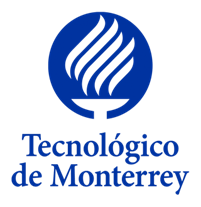

## TC 5033
### Word Embeddings
## Team Members:
- A01200230 - Armando Bringas Corpus

<br>

#### Activity 3a: Exploring Word Embeddings with GloVe and Numpy
<br>

- Objective:
    - To understand the concept of word embeddings and their significance in Natural Language Processing.
    - To learn how to manipulate and visualize high-dimensional data using dimensionality reduction techniques like PCA and t-SNE.
    - To gain hands-on experience in implementing word similarity and analogies using GloVe embeddings and Numpy.
    
<br>

- Instructions:
    - Download GloVe pre-trained vectors from the provided link in Canvas, the official public project: 
    Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation
    https://nlp.stanford.edu/data/glove.6B.zip

    - Create a dictorionay of the embeddings so that you carry out fast look ups. Save that dictionary e.g. as a serialized file for faster loading in future uses.
    
    - PCA and t-SNE Visualization: After loading the GloVe embeddings, use Numpy and Sklearn to perform PCA and t-SNE to reduce the dimensionality of the embeddings and visualize them in a 2D or 3D space.

    - Word Similarity: Implement a function that takes a word as input and returns the 'n' most similar words based on their embeddings. You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Word Analogies: Implement a function to solve analogies between words. For example, "man is to king as woman is to ____". You should use Numpy to implement this function, using libraries that already implement this function (e.g. Gensim) will result in zero points.

    - Submission: This activity is to be submitted in teams of 3 or 4. Only one person should submit the final work, with the full names of all team members included in a markdown cell at the beginning of the notebook.
    
<br>

- Evaluation Criteria:

    - Code Quality (40%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity.
    
   - Functionality (60%): All functions should work as intended, without errors.
       - Visualization of PCA and t-SNE (10% each for a total of 20%)
       - Similarity function (20%)
       - Analogy function (20%)

#### Import libraries

In [1]:
# Import libraries
import torch
import torch.nn.functional as F
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
import pickle

from typing import Dict, List, Tuple
plt.style.use('ggplot')

import seaborn as sns

In [2]:
# Check torch version
torch.__version__

'2.1.0'

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### Load file

In [4]:
# PATH = '/media/pepe/DataUbuntu/Databases/glove_embeddings/glove.6B.200d.txt'
PATH = 'data/glove_embeddings/glove.6B.50d.txt'
emb_dim = 50

In [5]:
# Create dictionary with embeddings
def create_emb_dictionary(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

In [6]:
# create dictionary
embeddings_dict = create_emb_dictionary(PATH)

In [7]:
# Serialize
with open('data/glove_embeddings/embeddings_dict_50D.pkl', 'wb') as f:
    pickle.dump(embeddings_dict, f)

# Deserialize
with open('data/glove_embeddings/embeddings_dict_50D.pkl', 'rb') as f:
    embeddings_dict = pickle.load(f)

#### See some embeddings

In [8]:
# Show some
def show_n_first_words(path, n_words):
        with open(path, 'r') as f:
            for i, line in enumerate(f):
                print(line.split(), len(line.split()[1:]))
                if i>=n_words: break

In [9]:
show_n_first_words(PATH, 5)

['the', '0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457', '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843', '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658', '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801', '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823', '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071', '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449', '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871', '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785', '0.0027849', '-0.18411', '-0.11514', '-0.78581'] 50
[',', '0.013441', '0.23682', '-0.16899', '0.40951', '0.63812', '0.47709', '-0.42852', '-0.55641', '-0.364', '-0.23938', '0.13001', '-0.063734', '-0.39575', '-0.48162', '0.23291', '0.090201', '-0.13324', '0.078639', '-0.41634', '-0.15428', '0.10068', '0.48891', '0.31226', '-0.1252', '-0.037512', '-1.5179', '0.12612', '-0.02442', '-0.042961', '-0.28351', '3.5416', '-0.11956', '-0.014533', '-0.

### Plot some embeddings

In [10]:
def plot_embeddings(emb_path, words2show, emb_dim, embeddings_dict, func = PCA):
    
    # Extract the embeddings for the specified words
    selected_embeddings = np.array([embeddings_dict[word] for word in words2show if word in embeddings_dict])
    
    # Fit the model and initialize the dimensionality reduction using PCA or TSNE
    if func == PCA:
        model = PCA(n_components=2)
        reduced_embeddings = model.fit_transform(selected_embeddings)
    elif func == TSNE:
        model = TSNE(n_components=2)
        reduced_embeddings = model.fit_transform(selected_embeddings)
    else:
        model = func(n_components=2)
        reduced_embeddings = model.fit_transform(selected_embeddings)

    # Use Seaborn for plotting
    selected_words = [word for word in words2show if word in embeddings_dict] 
    sns.set_context("talk", font_scale=0.75)
    plt.figure(figsize=(14, 10))
    
    plot = sns.scatterplot(
        x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], 
        hue=np.arange(len(selected_embeddings)), palette="husl", legend=False, s=100
    )
    
    for i, word in enumerate(selected_words):
        plot.text(reduced_embeddings[i, 0] + 0.02, reduced_embeddings[i, 1] + 0.02, word)
    
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.title(f'{func.__name__} visualization of word embeddings')
    plt.grid(True)
    plt.show()

In [11]:
words= ['burger', 'tortilla', 'bread', 'pizza', 'beef', 'steak', 'fries', 'chips', 
            'argentina', 'mexico', 'spain', 'usa', 'france', 'italy', 'greece', 'china',
            'water', 'beer', 'tequila', 'wine', 'whisky', 'brandy', 'vodka', 'coffee', 'tea',
            'apple', 'banana', 'orange', 'lemon', 'grapefruit', 'grape', 'strawberry', 'raspberry',
            'school', 'work', 'university', 'highschool']

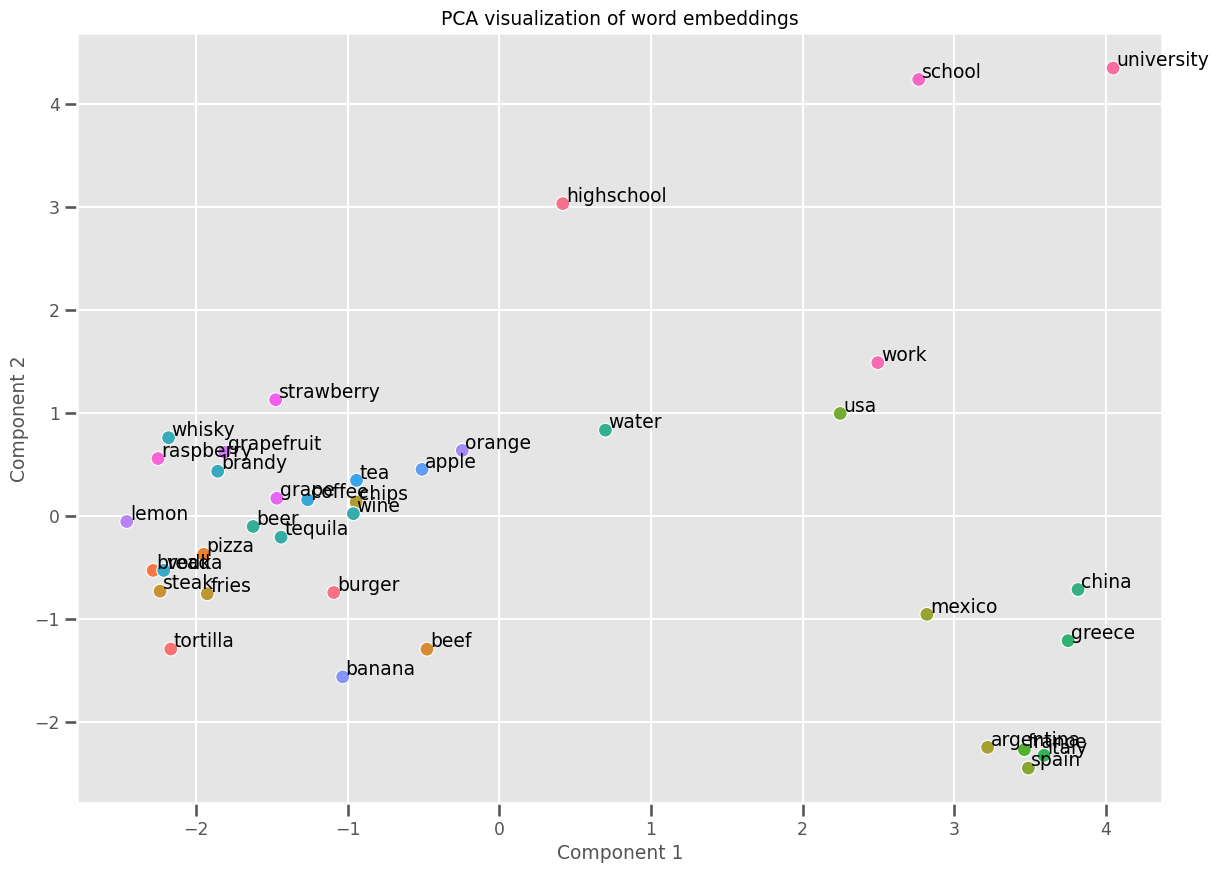

In [12]:
plot_embeddings(PATH, words, emb_dim, embeddings_dict, PCA)

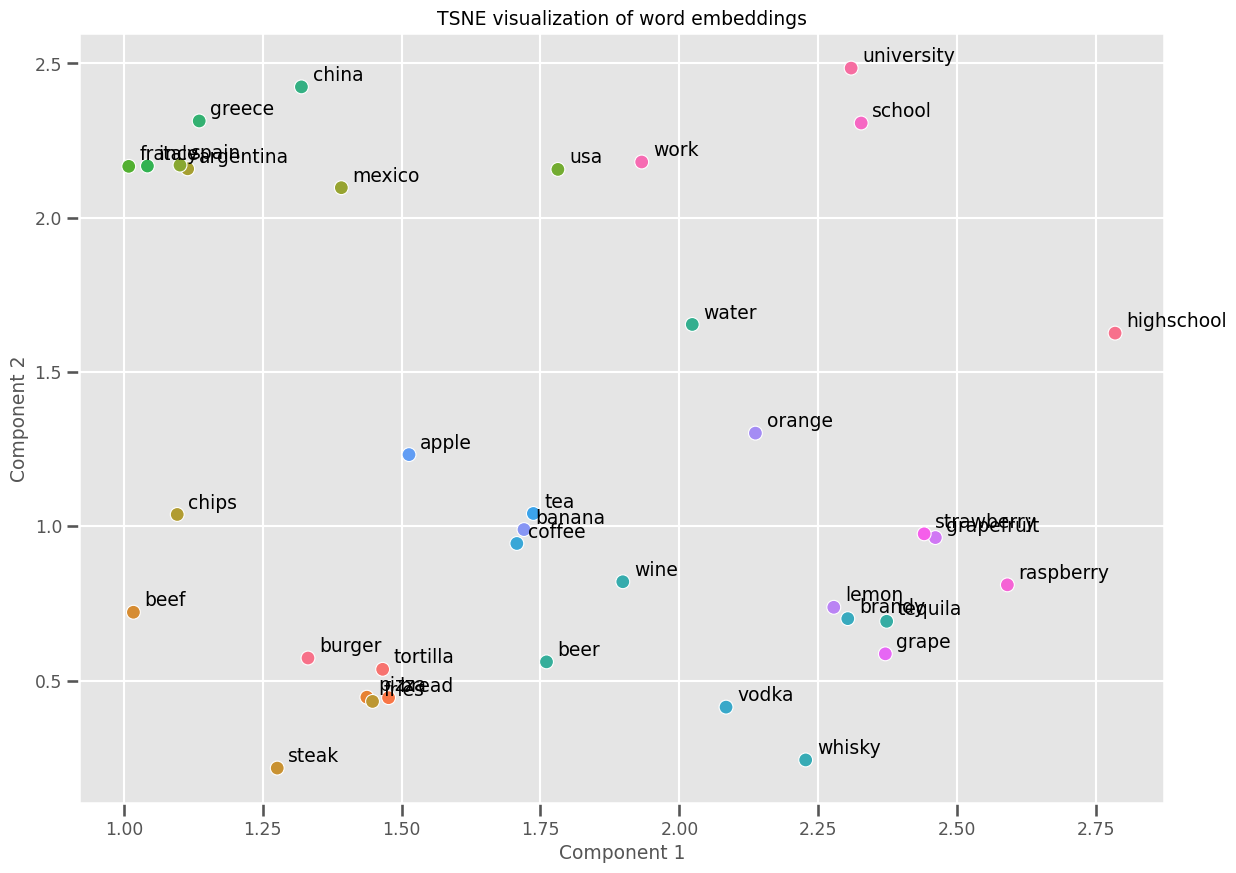

In [13]:
# t-SNE dimensionality reduction for visualization
embeddings = plot_embeddings(PATH, words, emb_dim, embeddings_dict, TSNE)

### Let us compute analogies

#### Analogy Function

In [14]:
def cosine_similarity(vec_a, vec_b):
    # Compute the cosine similarity between two vectors
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    
    return dot_product / (norm_a * norm_b)

In [15]:
# analogy
def analogy(word_1, word_2, word_3, embeddings_dict):
    # Calculate the target vector for the analogy
    target_vector = embeddings_dict[word_2] - embeddings_dict[word_1] + embeddings_dict[word_3]

    # Initialize variables to keep track of the closest word and highest similarity
    closest_word = None
    highest_similarity = -1  # Start with -1 as cosine similarity ranges from -1 to 1

    # Define exclusion set for input words
    exclusion_words = {word_1, word_2, word_3}

    # Iterate through the embeddings to find the closest word
    for word, vector in embeddings_dict.items():
        if word not in exclusion_words:
            similarity = cosine_similarity(target_vector, vector)
            if similarity > highest_similarity:
                highest_similarity = similarity
                closest_word = word

    return closest_word

In [16]:
sample_words = ['man', 'king', 'woman']

analogy_1 = analogy(sample_words[0], sample_words[1], sample_words[2], embeddings_dict)
print(f"{sample_words[0]} is to {sample_words[1]} as {sample_words[2]} is to {analogy_1}")

man is to king as woman is to queen


##### For the sake of joy test on another example

In [17]:
sample_words = ['paris', 'france', 'rome']

analogy_2 = analogy(sample_words[0], sample_words[1], sample_words[2], embeddings_dict)
print(f"{sample_words[0]} is to {sample_words[1]} as {sample_words[2]} is to {analogy_2}")

paris is to france as rome is to italy


#### Similarity function

In [18]:
def find_most_similar(word, embeddings_dict, top_n=10):
    # Retrieve the embedding vector for the specified word
    target_vector = embeddings_dict[word]
    
    # Initialize a list to store tuples of (similarity score, word)
    similarities = []

    # Iterate over each word and its embedding in the dictionary
    for other_word, other_vector in embeddings_dict.items():
        # Skip the target word itself
        if other_word != word:
            # Compute the cosine similarity between the target word and other words
            similarity = cosine_similarity(target_vector, other_vector)
            # Append the similarity and other_word as a tuple to the list
            similarities.append((similarity, other_word))
    
    # Sort the list of tuples based on the similarity score in descending order
    # Take the top N similar words based on the similarity score
    most_similar_words = sorted(similarities, key=lambda x: x[0], reverse=True)[:top_n]
    
    # Extract the words from the tuples and return them
    return most_similar_words # [word for _, word in most_similar_words]

In [19]:
word = 'mexico'

most_similar = find_most_similar(word, embeddings_dict)

print(f"Words most similar to '{word}':\n")
for i, (score, similar_word) in enumerate(most_similar, 1):
    print(f"{i} ---> {similar_word} (score: {score:.4f})")

Words most similar to 'mexico':

1 ---> mexican (score: 0.8551)
2 ---> venezuela (score: 0.8497)
3 ---> colombia (score: 0.8490)
4 ---> peru (score: 0.8446)
5 ---> chile (score: 0.8439)
6 ---> puerto (score: 0.8363)
7 ---> rico (score: 0.8195)
8 ---> cuba (score: 0.8125)
9 ---> guatemala (score: 0.8114)
10 ---> panama (score: 0.8097)


##### For the sake of joy, test on another example

In [20]:
word = 'cat'

most_similar = find_most_similar(word, embeddings_dict)

print(f"Words most similar to '{word}':\n")
for i, (score, similar_word) in enumerate(most_similar, 1):
    print(f"{i} ---> {similar_word} (score: {score:.4f})")

Words most similar to 'cat':

1 ---> dog (score: 0.9218)
2 ---> rabbit (score: 0.8488)
3 ---> monkey (score: 0.8041)
4 ---> rat (score: 0.7892)
5 ---> cats (score: 0.7865)
6 ---> snake (score: 0.7799)
7 ---> dogs (score: 0.7796)
8 ---> pet (score: 0.7792)
9 ---> mouse (score: 0.7732)
10 ---> bite (score: 0.7729)
